In [1]:
import numpy as np
import pandas as pd
import pickle
import json
import seaborn as sb
import numpy as np
from collections import defaultdict
import sys
import chardet
import matplotlib.pyplot as plt
# from transformers import GPT2Tokenizer
%matplotlib inline

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Distribution of predictability values

In [2]:
def read_in_pred_files(pred_map_filepaths):
    pos_pred_maps = dict()
    for predictor, filepath in pred_map_filepaths.items():
        with open(filepath) as f:
            pos_pred_maps[predictor]=json.load(f)
    return pos_pred_maps

In [3]:
def text_words_predictions(pos_pred_map,predictor):
    
    pred_values = defaultdict(list)
    
    for text, words in pos_pred_map.items():
        for word, predictions in words.items():
            pred_value = 0.0
            if predictions['target'] in predictions['predictions'].keys():
                pred_value = predictions['predictions'][predictions['target']]
            if pred_value <= 1: # to exclude mistaken value from cloze data: 1.025
                pred_values['text_word'].append(predictions['target'])
                pred_values['prediction'].append(pred_value)
                pred_values['predictor'].append(predictor)
                
    return pred_values

In [4]:
# read in predictions
pred_map_filepaths = {'cloze':'../data/processed/prediction_map_Provo_Corpus_cloze_continuous_reading_english.json',
                      'GPT2': '../data/processed/prediction_map_Provo_Corpus_language_model_continuous_reading_english_topkall.json'}
pred_maps = read_in_pred_files(pred_map_filepaths)

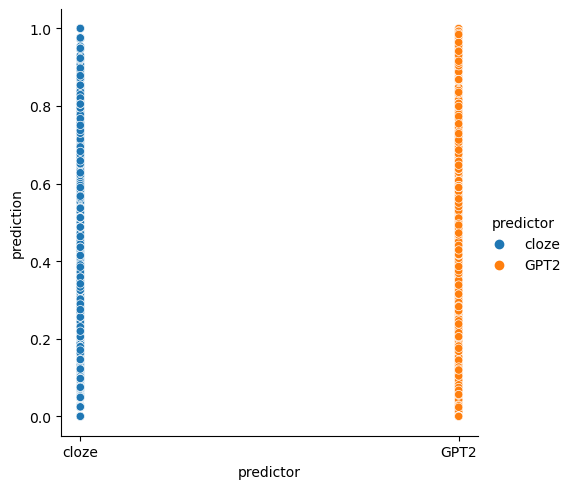

In [5]:
# compare target predictions from cloze and gtp2
target_predictions = defaultdict(list)

for predictor, pred_map in pred_maps.items():
    pred_values = text_words_predictions(pred_map,predictor)
    target_predictions['prediction'].extend(pred_values['prediction'])
    target_predictions['text_word'].extend(pred_values['text_word'])
    target_predictions['predictor'].extend(pred_values['predictor'])
    
pred_value_counts_df = pd.DataFrame.from_dict(target_predictions)
# pred_value_counts_df.to_csv('../data/processed/predictions_text_words.csv',sep='\t', index=False)
sb.relplot(data=target_predictions, x = 'predictor', y = 'prediction', hue = 'predictor', kind = 'scatter')

In [6]:
def compute_frequency_predictions(predictions):
    
    pred_values, counts, predictors, proportion = [],[],[],[]
    
    for predictor in set(predictions['predictor']):
        pred_value_counts = defaultdict(int)
        for prediction, a_predictor in zip(predictions['prediction'],predictions['predictor']):
            if predictor == a_predictor:
                pred_value_counts[round(prediction,3)] += 1
        pred_values.extend(pred_value_counts.keys())
        counts.extend(pred_value_counts.values())
        proportion.extend([round(value/sum(counts),3) for value in pred_value_counts.values()])

        for pred_value in range(len(pred_value_counts.keys())): 
            predictors.append(predictor)

        assert len(pred_values) == len(counts) == len(predictors), print(len(pred_values),len(counts),len(predictors))

    pred_value_counts_col = {'predictability': pred_values,
                             'counts': counts,
                             'proportion': proportion,
                             'predictor': predictors}
    return pred_value_counts_col

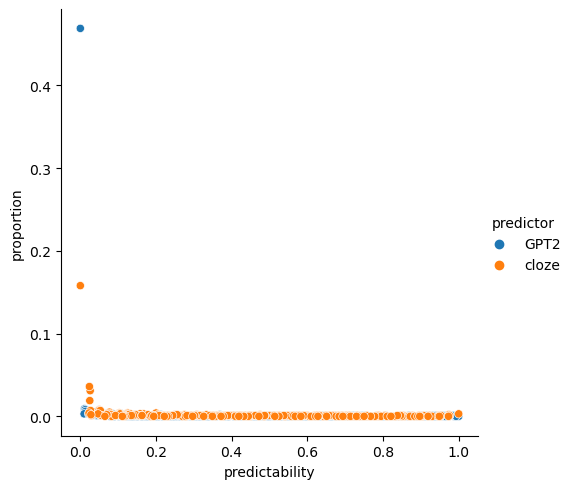

In [7]:
# count pred values in each predictor only including the predictability of target words (words in text) AND taking the pred value of word in text in GPT2
pred_value_counts_col = compute_frequency_predictions(target_predictions)
pred_value_counts_df = pd.DataFrame.from_dict(pred_value_counts_col)
pred_value_counts_df.sort_values(by='predictability', ascending=True, inplace=True)
pred_value_counts_df.to_csv('../data/processed/predictions_distribution.csv',sep='\t', index=False)
sb.relplot(data=pred_value_counts_col, x = 'predictability', y = 'proportion', hue = 'predictor', kind = 'scatter')

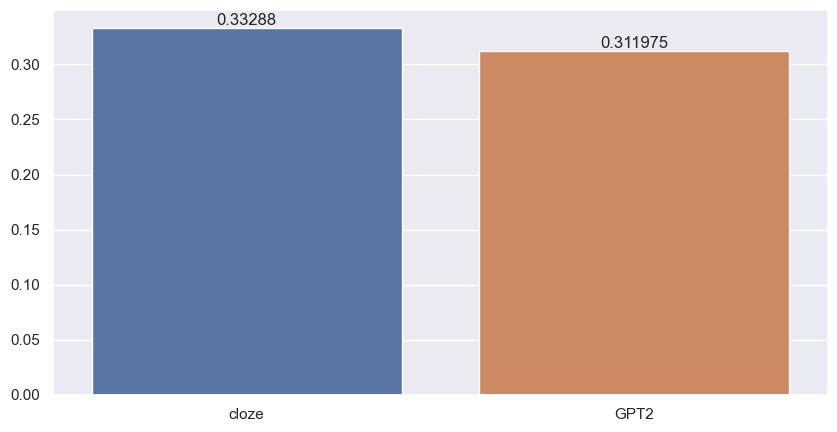

In [8]:
# proportion of unknown predicted tokens per target word in relation to model lexicon
unknown_map_filepaths = {'cloze': '../data/processed/prediction_map_Provo_Corpus_cloze_continuous_reading_english_unknown.json',
                      'GPT2': '../data/processed/prediction_map_Provo_Corpus_language_model_continuous_reading_english_topkall_unknown.json'}

pred_maps_unknown = read_in_pred_files(unknown_map_filepaths)

predictors, proportion = [],[]

for predictor in pred_maps.keys():
    
    proportions = []
    
    for text, info in pred_maps_unknown[predictor].items():
        for pos, pos_info in info.items():
            unknown_predictions = pos_info['predictions'].keys()
            all_predictions = pred_maps[predictor][text][pos]['predictions'].keys()
            if len(all_predictions) > 0:
                proportion_unknown = len(unknown_predictions)/len(all_predictions)
                proportions.append(proportion_unknown)
                
    proportion.append(sum(proportions)/len(proportions))
    predictors.append(predictor)
    
assert len(predictors) == len(proportion)

sb.set(rc={'figure.figsize': (10,5)})
ax = sb.barplot(x=predictors, y=proportion)
for i in ax.containers:
    ax.bar_label(i,)

In [9]:
# check the average number of predictions from language model
n_predictions = []
for text, info in pred_maps['GPT2'].items():
    for pos, pos_info in info.items():
        predictions = pos_info['predictions'].keys()
        n_predictions.append(len(predictions))
print('Average number of predictions: ', sum(n_predictions)/len(n_predictions))
print('Range: ', min(n_predictions), '-',max(n_predictions))

Average number of predictions:  10.435105987355895
Range:  0 - 36


In [ ]:
# check how many text words correspond to a multi-token in gpt-2 and thus are not in lexicon
unknown = dict()
total = 0
# tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
for text, info in pred_maps['GPT2'].items():
    for pos, pos_info in info.items():
        target_word = pos_info['target']
        target_word = ' ' + target_word
        target_token = tokenizer.encode(target_word, return_tensors='pt')
        print(target_token, [tokenizer.decode(token) for token in target_token[0]])
        if target_token.size(dim=1) > 1:
             unknown[target_word] = target_token
        total += 1
print('Unknown target words: ', len(unknown.keys())/total, '%')

# Word prediction accuracy

In [11]:
acc = []
for predictor, texts in pred_maps.items():
    for info in texts.values():
        for predictions in info.values():
            if predictions['target'] in predictions['predictions'].keys():
                acc.append(1)
            elif predictor=='GPT2' and prediction
            else: 
                acc.append(0)
    acc_score = sum(acc)/len(acc)
    print(f'{predictor} accuracy: {acc_score}')

cloze accuracy: 0.6834077380952381
GPT2 accuracy: 0.6070299423470337
